## Step 1: Load Dataset and Convert to Graph
CSV → graph → Data object


In [11]:
import pandas as pd
import torch
from torch_geometric.data import Data

def csv_to_graph(csv_path):
    df = pd.read_csv(csv_path)

    # Node features
    x = torch.tensor(df[['X','Y','Z','MaximumInscribedSphereRadius']].values,
                     dtype=torch.float)

    # Edges
    edge_index = []
    for i in range(len(df)-1):
        edge_index.append([i, i+1])
        edge_index.append([i+1, i])  # bidirectional

    edge_index = torch.tensor(edge_index, dtype=torch.long).t()

    return Data(x=x, edge_index=edge_index)


In [12]:
import glob

dataset = []
csv_files = glob.glob("../data/*.csv")

for file in csv_files:
    data = csv_to_graph(file)
    dataset.append(data)

print("Total cases:", len(dataset))


Total cases: 24


## Step 2: Train Test Split

In [13]:
from sklearn.model_selection import train_test_split

# first split: train + temp
train_data, temp_data = train_test_split( dataset, test_size=8, random_state=42)

# second split: validation + test
val_data, test_data = train_test_split( temp_data, test_size=4, random_state=42)

print(len(train_data), len(val_data), len(test_data))


16 4 4


## Step 3: Traning Target

In [14]:
for data in train_data + val_data + test_data:
    data.y = data.x[:, 3]   # radius


## Step 4: Train Model & Save Model

In [20]:
from torch_geometric.loader import DataLoader
from GNN_model import VesselGNN
import torch.nn as nn


train_losses = []
val_losses = []


best_val_loss = float('inf')
best_epoch = 0

model = VesselGNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()


train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=1, shuffle=False)

num_epochs = 100

for epoch in range(num_epochs):
    # ---- TRAIN ----
    model.train()
    train_loss = 0

    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = loss_fn(out[:, 0], data.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # ---- VALIDATION ----
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            out = model(data)
            loss = loss_fn(out[:, 0], data.y)
            val_loss += loss.item()
            
    # ---- CHECK AND SAVE MODEL ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch + 1

        torch.save({
            'epoch': best_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': best_val_loss
        }, "best_vessel_gnn.pth")

        print(f"Best model saved at epoch {best_epoch}")
    
    
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(
        f"Epoch {epoch+1:03d} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f}"
    )


Best model saved at epoch 1
Epoch 001 | Train Loss: 8.8271 | Val Loss: 1.6991
Best model saved at epoch 2
Epoch 002 | Train Loss: 0.9385 | Val Loss: 0.5177
Best model saved at epoch 3
Epoch 003 | Train Loss: 0.5990 | Val Loss: 0.1684
Epoch 004 | Train Loss: 0.4407 | Val Loss: 0.2218
Best model saved at epoch 5
Epoch 005 | Train Loss: 0.2768 | Val Loss: 0.1644
Best model saved at epoch 6
Epoch 006 | Train Loss: 0.2786 | Val Loss: 0.1262
Epoch 007 | Train Loss: 0.2212 | Val Loss: 0.1420
Best model saved at epoch 8
Epoch 008 | Train Loss: 0.1643 | Val Loss: 0.1257
Epoch 009 | Train Loss: 0.1186 | Val Loss: 0.1808
Best model saved at epoch 10
Epoch 010 | Train Loss: 0.1201 | Val Loss: 0.1051
Epoch 011 | Train Loss: 0.2062 | Val Loss: 0.1857
Epoch 012 | Train Loss: 0.1576 | Val Loss: 0.2360
Best model saved at epoch 13
Epoch 013 | Train Loss: 0.0992 | Val Loss: 0.0571
Best model saved at epoch 14
Epoch 014 | Train Loss: 0.0534 | Val Loss: 0.0382
Epoch 015 | Train Loss: 0.0745 | Val Loss: 0.

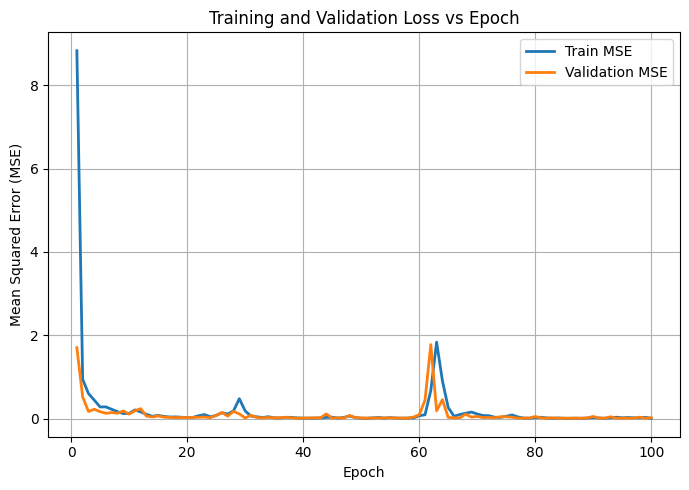

<Figure size 640x480 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(7,5))
plt.plot(epochs, train_losses, label="Train MSE", linewidth=2)
plt.plot(epochs, val_losses, label="Validation MSE", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Training and Validation Loss vs Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig("Figure_5_1_TrainValLoss.png", dpi=300)



## Step 5: Testing (GENERALIZATION CHECK)

In [16]:
model.eval()
with torch.no_grad():
    for data in test_data:
        out = model(data)


## Step 6: Visualization 

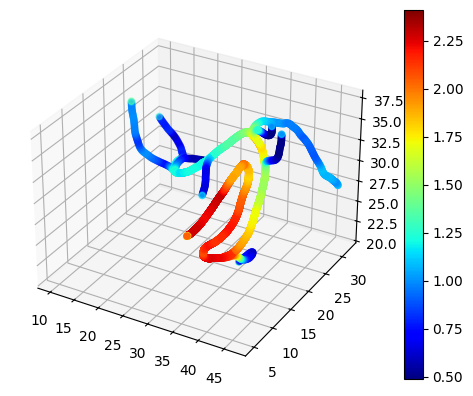

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

data = test_data[0]
out = model(data).detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    data.x[:,0], data.x[:,1], data.x[:,2],
    c=out[:,0], cmap='jet'
)


plt.colorbar(sc)
plt.show()


## Step 7: Visulization of two patients

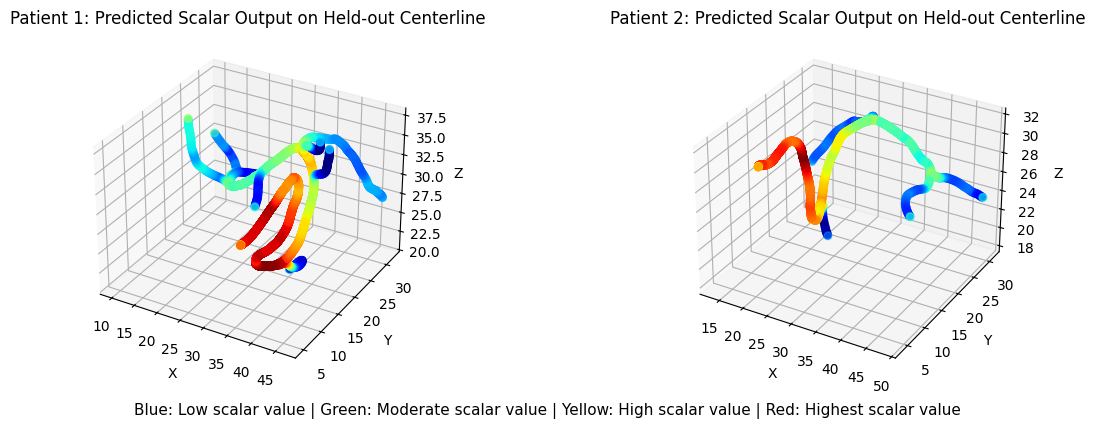

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# -------------------------
# Patient 1
# -------------------------
data1 = test_data[0]
out1 = model(data1).detach().numpy()

# -------------------------
# Patient 2
# -------------------------
data2 = test_data[1]
out2 = model(data2).detach().numpy()

# -------------------------
# Create side-by-side plots
# -------------------------
fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

sc1 = ax1.scatter(
    data1.x[:,0], data1.x[:,1], data1.x[:,2],
    c=out1[:,0],
    cmap='jet',
    s=30
)
ax1.set_title("Patient 1: Predicted Scalar Output on Held-out Centerline")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")

sc2 = ax2.scatter(
    data2.x[:,0], data2.x[:,1], data2.x[:,2],
    c=out2[:,0],
    cmap='jet',
    s=30
)
ax2.set_title("Patient 2: Predicted Scalar Output on Held-out Centerline")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_zlabel("Z")

# # -------------------------
# # Shared colorbar
# # -------------------------
# cbar = fig.colorbar(sc2, ax=[ax1, ax2], shrink=0.7)
# cbar.set_label("Relative Blood Flow Intensity")

# -------------------------
# Color meaning label
# -------------------------
fig.text(
    0.5, -0.05,
    "Blue: Low scalar value | Green: Moderate scalar value | Yellow: High scalar value | Red: Highest scalar value",
    ha="center",
    fontsize=11
)

plt.tight_layout()
plt.show()
